<a href="https://colab.research.google.com/github/vikashbhushan189/CODECRAFT_GA_05/blob/main/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
# Load and preprocess image
def load_and_preprocess_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    image = in_transforms(image).unsqueeze(0)
    return image.to(device)

In [ ]:
# Deprocess image
def deprocess_image(tensor):
    image = tensor.to('cpu').clone().detach().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * torch.tensor((0.229, 0.224, 0.225)).numpy() + torch.tensor((0.485, 0.456, 0.406)).numpy()
    image = image.clip(0, 1)
    return image

In [ ]:
# Gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [ ]:
# VGG model
def get_vgg():
    vgg = models.vgg19(pretrained=True).features
    for param in vgg.parameters():
        param.requires_grad_(False)
    return vgg.to(device)

In [ ]:
# Extract features
def extract_features(image, model):
    layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Image Credits: Tensorflow Doc
content_path = '/content/YellowLabradorLooking_new.jpg'
style_path = '/content/Vassily_Kandinsky,_1913_-_Composition_7.jpg'

In [ ]:
content = load_and_preprocess_image(content_path).to(device)
style = load_and_preprocess_image(style_path).to(device)

In [ ]:
# Load VGG19
vgg = get_vgg()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 178MB/s]


In [ ]:
content_features = extract_features(content, vgg)
style_features = extract_features(style, vgg)

In [ ]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [ ]:
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# Weights and optimizer
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1
style_weight = 1e6
optimizer = optim.Adam([target], lr=0.003)

In [ ]:
# Training loop
epochs = 2000
show_every = 400

Epoch:  400 Total loss:  640416131055616.0


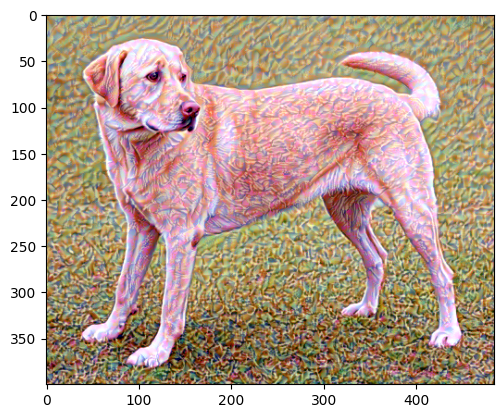

Epoch:  800 Total loss:  312772134961152.0


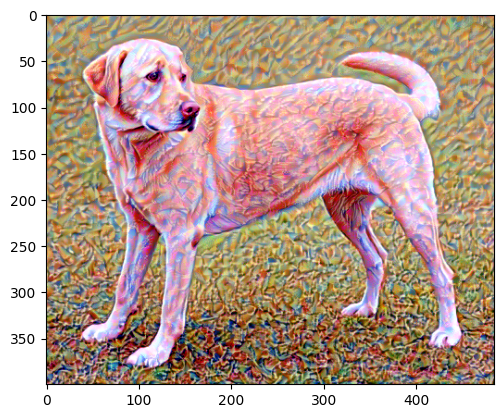

Epoch:  1200 Total loss:  163246304657408.0


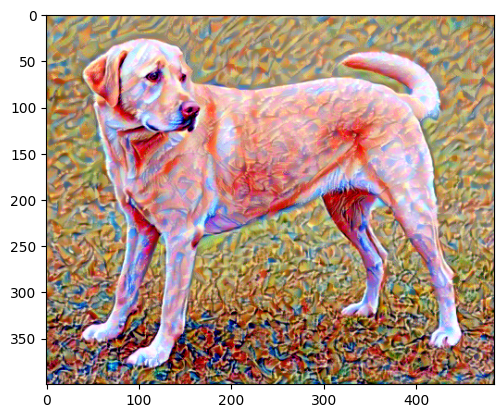

Epoch:  1600 Total loss:  83531896193024.0


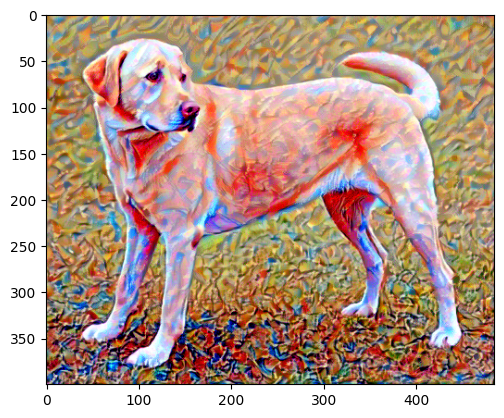

Epoch:  2000 Total loss:  49257637740544.0


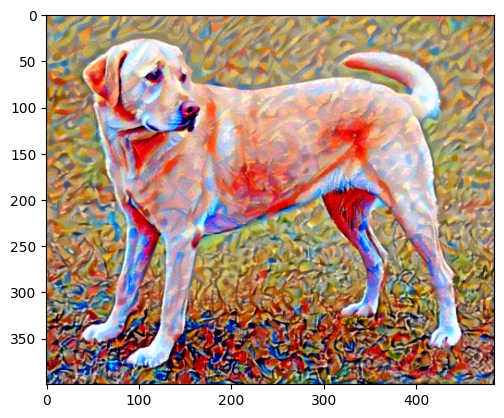

In [ ]:
for epoch in range(1, epochs + 1):
    target_features = extract_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_gram = gram_matrix(target_features[layer])
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % show_every == 0:
        print('Epoch: ', epoch, 'Total loss: ', total_loss.item())
        plt.imshow(deprocess_image(target))
        plt.show()


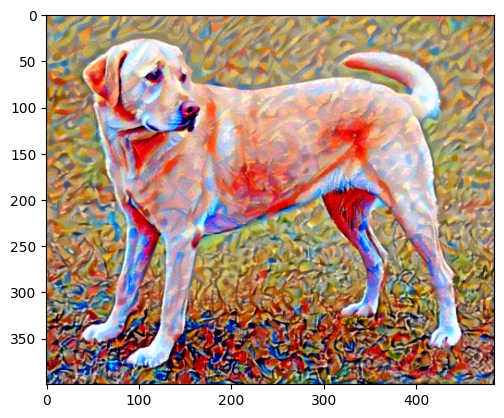

In [ ]:
# Display final image
plt.imshow(deprocess_image(target))
plt.show()